## Exercise 1: Logistic Regression
*Implement one-vs-all logistic regression to recognize hand-written digits*

In [1]:
from numpy import *
from mpl_toolkits.mplot3d import Axes3D
%pylab inline
import scipy.optimize as op
import pandas as pd
import os
import scipy.io as sio

Populating the interactive namespace from numpy and matplotlib


In [2]:
from math import *

*Read in images*

In [3]:
ls *.mat

 Volume in drive C is Windows
 Volume Serial Number is 0C55-2DB0

 Directory of C:\Users\Mya\Documents\Coursera\Machine Learning\machine-learning-ex3

07/30/2015  02:13 PM         7,511,764 ex3data1.mat
07/30/2015  02:13 PM            79,592 ex3weights.mat
               2 File(s)      7,591,356 bytes
               0 Dir(s)  70,752,063,488 bytes free


In [4]:
data = sio.loadmat('ex3data1.mat')

In [5]:
X = data["X"]
y = data["y"]
shape(X), shape(y)

((5000, 400), (5000, 1))

*Visualize one of the test images. Images are unrolled in the data to be a single vector of length 400. To see them we need to reshape them to 20x20 pixels.*

In [6]:
testim = X[0,:].reshape(20,20)

1.04748345631


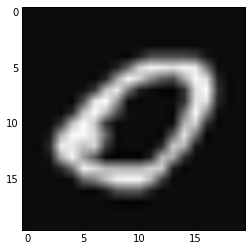

In [7]:
print(testim.max())
implot = imshow(testim)
implot.set_cmap('gray')

*Make one large image with the contents of each small image in cells to see many of the images at once *

In [8]:
numx = 40
numy = 40

In [9]:
img_all = zeros((numx*20,numy*20))
img_all.shape

(800, 800)

In [10]:
for col in range(0,numx):
    for row in range(0,numy):
        imnum = row*numx+col
        subim = X[imnum,:].reshape(20,20)
        img_all[col*20:(col+1)*20,row*20:(row+1)*20]=subim

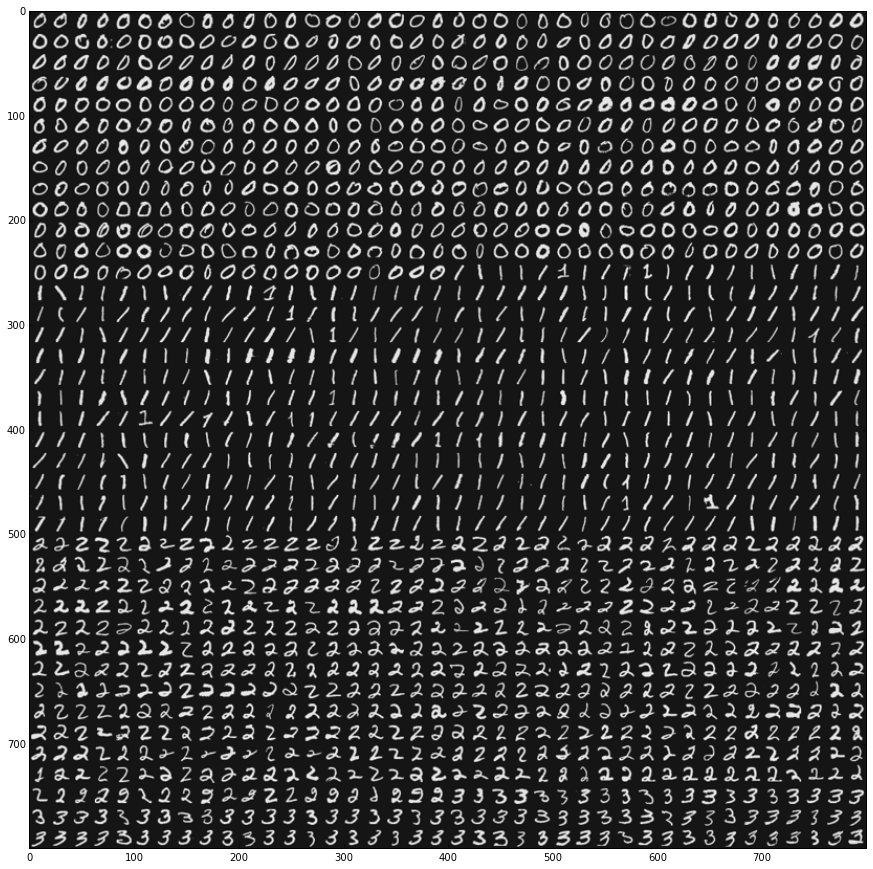

In [11]:
fig = figure(figsize=(15, 15))
implot = imshow(img_all.T)
implot.set_cmap('gray')

*Set up parameters, add ones to X matrix for regression as usual*

In [12]:
rows = len(y)
params = shape(X)[1]
(rows, params)

(5000, 400)

In [13]:
X = hstack((ones((rows,1)),X))
X.shape

(5000, 401)

*Initialize parameters. Since we are training 10 separate logistic models using one-vs-all, we need separate parameters for each number we want to recognize. Each pixel counts as an independent feature in the data (+1 for the constant term), so there are 10x401 parameters.* 

In [14]:
all_theta = zeros((10,params))

*The trickiest part of this I found was getting all of the dimensions correct for the proper vectorization. Here, I check to make sure they are correct.*

In [15]:
theta = zeros((1,params+1))
y0 = (y==10).astype(int)
print(y0)
X.shape, y0.shape, theta.shape

[[1]
 [1]
 [1]
 ..., 
 [0]
 [0]
 [0]]


((5000, 401), (5000, 1), (1, 401))

*Define sigmoid, cost, and gradient functions as usual.*

In [16]:
def sigmoid(z):
    g = 1/(1+numpy.exp(-z))
    return g

In [17]:
def costFunction(theta, X, y, LR):
    m = len(y)
    z = dot(X,theta.T)
    h = sigmoid(z)
    cost = (-dot(y.T,numpy.log(h))-dot(1-y.T,numpy.log(1-h)))/m
    theta = squeeze(theta)
    cost += LR/2/m*dot(theta[1:],theta[1:])
    return cost

In [18]:
def gradient(theta, X, y, LR):
    theta = matrix(theta)
    X = matrix(X)
    y = matrix(y)
    m = len(y)
    params = shape(X)[1]
    z = X*theta.T
    h = sigmoid(z)
    grad = (h-y).T*X/m
    grad[0,1:params] += LR/m*theta[0,1:]
    return grad

*Make sure that the gradient comes out the right size*

In [19]:
gradient(theta, X, y0, 1).shape

(1, 401)

*Find the parameters, theta, that minimize the cost. Test it on y0, which is the vector identifying thet 1's in the data set.*

In [20]:
fmin = op.minimize(fun=costFunction, x0=theta, args=(X, y0, 1), method='TNC', jac=gradient)

fmin

In [21]:
fmin.x.shape

(401,)

*Define predict, which uses the regression model to predict whether a character (0-9) has been detected or not.*

In [22]:
def predict(theta, X):
    probability = sigmoid(dot(X,theta.T))
    return [1 if x >= 0.5 else 0 for x in probability]

*Check our predictions for y0 (the 0's). This will give the number of errors in identifying zeros.*

In [23]:
sum(predict(fmin.x, X)-y0.T)/len(y0)

0

*Now repeat this procedure for each of the digits individually.*

In [24]:
def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    
    # k X (n + 1) array for the parameters of each of the k classifiers
    all_theta = zeros((num_labels, params))
    
    # labels are 1-indexed instead of 0-indexed
    for ii in range(1, num_labels + 1):
        theta = np.zeros(params)
        y_i = (y==ii).astype(int)
        print(ii) # just a progress bar
        
        # minimize the objective function
        fmin = op.minimize(fun=costFunction, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradient)
        all_theta[ii-1,:] = fmin.x
    
    return all_theta

In [25]:
all_theta = one_vs_all(X, y, 10, 0.1)

1
2
3
4
5
6
7
8
9
10


In [26]:
X.shape

(5000, 401)

*Check predictions for all of the data now.*

In [27]:
def predict_all(all_theta, X):
    probability = sigmoid(dot(X,all_theta.T))
    id = argmax(probability,axis = 1)+1
    return id

In [28]:
probability = sigmoid(dot(X,all_theta.T))
shape(probability)
argmax(probability,axis=1)+1

array([10, 10, 10, ...,  9,  9,  7])

In [29]:
id = predict_all(all_theta, X)

In [30]:
diff = id-y.T
diff.shape

(1, 5000)

*These are the indices of the errors. We can check them to see if there is anything funny about the data.*

In [31]:
errid = numpy.nonzero(diff)[1]
errid

array([ 142,  561,  675,  765, 1026, 1045, 1057, 1066, 1081, 1087, 1097,
       1112, 1130, 1145, 1153, 1213, 1231, 1311, 1362, 1393, 1399, 1408,
       1410, 1413, 1423, 1440, 1484, 1488, 1524, 1527, 1550, 1556, 1564,
       1599, 1607, 1611, 1617, 1626, 1629, 1630, 1700, 1701, 1707, 1719,
       1732, 1764, 1766, 1769, 1776, 1791, 1798, 1801, 1820, 1876, 1923,
       1959, 1970, 1976, 1981, 1999, 2087, 2093, 2112, 2118, 2166, 2171,
       2187, 2195, 2238, 2277, 2384, 2498, 2506, 2516, 2520, 2533, 2556,
       2570, 2574, 2578, 2593, 2598, 2616, 2618, 2619, 2620, 2675, 2697,
       2718, 2788, 2790, 2869, 2908, 2937, 2943, 2947, 2958, 3174, 3328,
       3382, 3616, 3627, 3629, 3660, 3668, 3722, 3725, 3732, 3795, 3823,
       3830, 3838, 3895, 3909, 3972, 4030, 4032, 4057, 4069, 4076, 4100,
       4110, 4125, 4168, 4177, 4183, 4197, 4248, 4249, 4250, 4252, 4265,
       4294, 4306, 4319, 4325, 4362, 4364, 4393, 4395, 4422, 4428, 4454,
       4455, 4471, 4477, 4503, 4506, 4509, 4526, 45

*The error rate is 3.5%.*

In [32]:
len(errid)/float(5000)

0.0354

## Exercise 2: Neural networks
*Implement neural networks to recognize hand-written digits*

*The weights for the neural network are provided for this data set, we just have to do the feedforward algorithm. The neural network has one internal layer, and Theta1 and Theta2 are the parameters which map from internal-middle and middle-output. The internal layer has size 25 (+1 for the constant).*

In [33]:
data = sio.loadmat('ex3weights.mat')

In [34]:
Theta1 = data["Theta1"]
Theta2 = data["Theta2"]

In [35]:
Theta1.shape, Theta2.shape, X.shape

((25, 401), (10, 26), (5000, 401))

*Implement feedforward algorithm, and use it to predict which digit is represented by the data.*

In [36]:
def NN_predict(Theta1, Theta2, X):
    rows = shape(X)[0]
    X = matrix(X)
    Theta1 = matrix(Theta1)
    Theta2 = matrix(Theta2)
    
    z2 = X*Theta1.T
    a2 = sigmoid(z2)
    a2 = insert(a2, 0, values=ones(rows), axis=1)
    
    z3 = a2*Theta2.T
    a3 = sigmoid(z3)
    
    id = array(argmax(a3,axis = 1)+1)

    
    return id

In [37]:
id = NN_predict(Theta1, Theta2, X)

In [38]:
print([id,y])

[array([[10],
       [10],
       [10],
       ..., 
       [ 9],
       [ 9],
       [ 9]]), array([[10],
       [10],
       [10],
       ..., 
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)]


In [39]:
diff = id-y
errs = numpy.nonzero(diff)[1]

*The error rate is 2.5%.*

In [40]:
len(errs)/float(5000)

0.0248